# Frauen an die Macht
Auswertung des Frauenanteils bei den Gemeindepräsidien im Kanton Bern. Verwendet wird eine Namensliste der Gemeindepräsidentinnen und Gemeindepräsidenten sowie eine Tabelle mit Basisinformationen zu den Gemeinden. Beide Dokumente sind auf der [Website des Kantons](https://www.jgk.be.ch/jgk/de/index/gemeinden/gemeinden/gemeindedaten.html) zu finden. 

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datenaufbereitung" data-toc-modified-id="Datenaufbereitung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datenaufbereitung</a></span></li><li><span><a href="#Auswertungen" data-toc-modified-id="Auswertungen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Auswertungen</a></span></li></ul></div>

## Datenaufbereitung

In [16]:
# Importieren der nötigen Bibliotheken. 
import pandas as pd
import geopandas as gpd
import numpy as np
from datawrapper import Datawrapper
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import dw_config

In [17]:
# Importieren der Grundlagedaten zu den Gemeinden (Stand: Ende 2018). 
df_gemeinden = pd.read_excel('https://www.jgk.be.ch/jgk/de/index/gemeinden/gemeinden/gemeindedaten.assetref/dam/documents/JGK/AGR/de/Gemeinden/Gemeindedaten/agr_gemeinden_gemeindedaten_gemeinden_rk_de.xlsx', skiprows=2)
df_gemeinden.columns = [x.split(' / ')[0] for x in df_gemeinden.columns]
df_gemeinden.set_index('BFS', inplace=True, drop=True)
df_gemeinden['Gemeinde'] = df_gemeinden['Gemeinde'].str.strip()
df_gemeinden['Gemeinde'] = df_gemeinden['Gemeinde'].str.replace('  ', ' ')
df_gemeinden.head()

,Gemeinde,Früherer Amtsbezirk,Regionalkonferenz,Verwaltungsregion,Verwaltungskreis,Wahlkreis ab 01.01.2011,Einwohner,Bemerkung
BFS,,,,,,,,
301,Aarberg,Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,4628,NaN
302,Bargen (BE),Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,999,NaN
303,Grossaffoltern,Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,3018,NaN
304,Kallnach,Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,2222,Fusion: 1.1.2019 Golaten/Kallnach (Kallnach) ...
305,Kappelen,Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,1419,NaN


In [18]:
# Importieren der Namensliste mit den Gemeindepräsidien.
df_präsidien = pd.read_excel('https://www.jgk.be.ch/jgk/de/index/gemeinden/gemeinden/gemeindedaten.assetref/dam/documents/JGK/AGR/de/Gemeinden/Gemeindedaten/agr_gemeinden_gemeindedaten_liste_gemeindepraesidien_kanton_bern_de.xlsx', skiprows=1)
df_präsidien.columns = [x.split(' / ')[0] for x in df_präsidien]
df_präsidien.head()

,Name,Vorname,Gemeinde
0,Affolter,Fritz,Aarberg
1,Bläuenstein,Kurt,Aarwangen
2,Gempeler,Markus,Adelboden
3,Frank,Urs,Aefligen
4,Krattiger,Stefan,Aegerten


In [19]:
# Wie viele Einträge hat der Präsidenten-Datensatz? 
len(df_präsidien)

346

In [20]:
# Wie viele Einträge hat der Gemeinde-Datensatz? 
len(df_gemeinden)

347

In [21]:
# Welche Gemeinde ist im Präsidenten-Datensatz nicht enthalten? 
g1 = df_gemeinden['Gemeinde'].tolist()
g2 = df_präsidien['Gemeinde'].tolist()
[x for x in g2 if x not in g1]

['Gurbrü', 'La Neuveville', 'Péry-La HeuttePéry-La Heutte']

In [22]:
# Im Datensatz fehlen zwei Gemeinden. Die Infos, die wir unten benötigen, werden nachgetragen. 
df_temp = pd.DataFrame([{'BFS': 665, 'Gemeinde': 'Gurbrü', 'Verwaltungskreis': 'Bern-Mittelland', 'Einwohner': 261}])
df_temp.set_index('BFS', inplace=True, drop=True)
df_gemeinden = df_gemeinden.append(df_temp)

In [23]:
# Zwei fehlerhafte Einträge wird korrigiert. 
df_präsidien.at[220, 'Gemeinde'] = 'Péry-La Heutte'
df_präsidien.at[147, 'Gemeinde'] = 'Neuveville'
df_präsidien.at[341, 'Name'] = 'Kaufmann'
df_präsidien.at[341, 'Vorname'] = 'Beatrice'

In [24]:
# Thurnen wird entfernt. Diese Gemeinde entsteht erst 2020. 
df_gemeinden = df_gemeinden[df_gemeinden['Gemeinde'] != 'Thurnen']

In [25]:
# Ein doppelter Eintrag wird entfernt. 
df_gemeinden = df_gemeinden.drop_duplicates()

In [26]:
# Die Fusion zwischen Kallnach und Golaten vom 1. Januar 2019 wird übernommen. 
i = df_gemeinden[df_gemeinden['Gemeinde'] == 'Kallnach'].index
e1 = df_gemeinden[df_gemeinden['Gemeinde'] == 'Kallnach']['Einwohner'].iloc[0]
e2 = df_gemeinden[df_gemeinden['Gemeinde'] == 'Golaten']['Einwohner'].iloc[0]
df_gemeinden.at[i, 'Einwohner'] = e1 + e2
df_gemeinden = df_gemeinden[df_gemeinden['Gemeinde'] != 'Golaten']

In [29]:
# Zur Kontrolle: Wie viele Gemeinden sind im Gemeindedatensatz verzeichnet? 
len(df_gemeinden)

346

In [30]:
# Zur Kontrolle: # Wie viele Gemeinden sind im Präsidialdatensatz verzeichnet? 
len(df_präsidien)

346

In [31]:
# Eine Liste mit Vornamen inklusive dem Geschlecht wird generiert.  
# Die Namensliste des Bundesamts für Statistik wird eingelesen. 
df_namen_2017 = pd.read_excel('../../morgenteam/2019-06-13_gender/daten/vornamen.xlsx', skiprows=4, usecols=[1,2,3], sheet_name='2017')
df_namen_2017.columns = ['vorname', 'weiblich', 'männlich']

df_namen_2016 = pd.read_excel('../../morgenteam/2019-06-13_gender/daten/vornamen.xlsx', skiprows=5, usecols=[0,1,2,3], sheet_name='2016')
df_namen_2016.columns = ['vorname', 'weiblich', 'männlich']

df_namen_2015 = pd.read_excel('../../morgenteam/2019-06-13_gender/daten/vornamen.xlsx', skiprows=5, usecols=[0,1,2,3], sheet_name='2015')
df_namen_2015.columns = ['vorname', 'weiblich', 'männlich']

# Die einzelnen Datenblätter werden zu einem zusammengefügt. 
df_namen = pd.concat([df_namen_2017, df_namen_2016], ignore_index=True, axis=0)
df_namen = pd.concat([df_namen, df_namen_2015], ignore_index=True, axis=0)

# Duplikate werden entfernt.
df_namen = df_namen.drop_duplicates(subset=['vorname'])
df_namen.index = df_namen['vorname']
del df_namen['vorname']
df_namen = df_namen.dropna(subset=['weiblich', 'männlich'])

df_namen['weiblich'] = df_namen['weiblich'].apply(lambda x: int(str(x).replace('*', '0')))
df_namen['männlich'] = df_namen['männlich'].apply(lambda x: int(str(x).replace('*', '0')))
df_namen.head()

# Behalten werden nur Namen, die zu mindestens drei Vierteln für ein bestimmtes Geschlecht stehen. 
def get_geschlecht(temp):
    r = int(temp[0]) / int((temp[0]) + int(temp[1]))
    if r > 0.75:
        return 'w'
    elif r < 0.25:
        return 'm'
    else:
        return 'unklar'
    
for index, row in df_namen.iterrows():
    df_namen.at[index, 'geschlecht'] = get_geschlecht([row['weiblich'], row['männlich']])
    
# Namen, bei denen die Geschlechterzuordnung unklar ist, werden ignoriert. 
df_namen = df_namen[df_namen['geschlecht'] != 'unklar']

df_namen.head()

,weiblich,männlich,geschlecht
vorname,,,
Aada,11,0,w
Aadam,0,5,m
Aadan,0,7,m
Aadel,0,3,m
Aaden,0,3,m


In [32]:
# Anhand der Vornamen aus dem Namensdatensatz wird das Geschlecht bestimmt.  
def mannoderfrau(vorname): 
    try:
        return df_namen.loc[vorname]['geschlecht']
    except: 
        return ''

df_präsidien['geschlecht'] = df_präsidien['Vorname'].apply(mannoderfrau)

In [33]:
# Zur Kontrolle: Wo konnte das Geschlecht nicht zugewiesen werden? 
df_präsidien[df_präsidien['geschlecht'] == '']

,Name,Vorname,Gemeinde,geschlecht
105,Widmer,Hans Ulrich,Heimiswil,
154,Gerber,Hans Ulrich,Lauperswil,
179,Wälti,Hans Peter,Merzligen,
197,Schweizer,Hans Rudolf,Niedermuhlern,
230,Mürner,Hans Ulrich,Reichenbach im Kandertal,
265,Mühlheim,Hans Rudolf,Schwadernau,
339,Baltensperger,Hans Peter,Wyssachen,


In [34]:
# Bei allen handelt es sich um Männer... Die fehlenden Information wird ergänzt. 
for i, r in df_präsidien[df_präsidien['geschlecht'] == ''].iterrows():
    df_präsidien.at[i, 'geschlecht'] = 'm'

In [35]:
# Zusammenführen der Datensätze. 
df = pd.merge(df_präsidien, df_gemeinden.reset_index(), left_on='Gemeinde' , right_on='Gemeinde', how='left')

In [19]:
# Die Daten werden exportiert. Nun können sie manuell kontrolliert und bearbeitet werden. 
df.to_excel('daten/rohdaten.xlsx')
!libreoffice daten/rohdaten.xlsx

## Auswertungen

In [36]:
# Die korrigierten Daten werden neu eingelesen. 
df = pd.read_excel('daten/rohdaten.xlsx', index_col='Unnamed: 0')

In [37]:
# Ein Blick auf die ersten paar Zeilen des Datensatzes. 
df.head()

,Name,Vorname,Gemeinde,geschlecht,BFS,Früherer Amtsbezirk,Regionalkonferenz,Verwaltungsregion,Verwaltungskreis,Wahlkreis ab 01.01.2011,Einwohner,Bemerkung
0,Affolter,Fritz,Aarberg,m,301,Aarberg,Biel/Bienne - Seeland - Jura bernois,Seeland,Seeland,Biel-Seeland,4628,NaN
1,Bläuenstein,Kurt,Aarwangen,m,321,Aarwangen,Oberaargau,Emmental-Oberaargau,Oberaargau,Oberaargau,4561,NaN
2,Gempeler,Markus,Adelboden,m,561,Frutigen,Thun Oberland-West,Oberland,Frutigen-Niedersimmental,Oberland,3390,NaN
3,Frank,Urs,Aefligen,m,401,Burgdorf,Emmental,Emmental-Oberaargau,Emmental,Emmental,1090,NaN
4,Krattiger,Stefan,Aegerten,m,731,Nidau,Biel/Bienne - Seeland - Jura bernois,Seeland,Biel/Bienne,Biel-Seeland,2159,NaN


In [38]:
# Wie viele Gemeindepräsidentinnen und Gemeindepräsidenten sind verzeichnet? 
len(df)

346

In [23]:
# Wie viele Frauen und wie viele Männer haben im Kanton Bern ein Gemeindepräsidium inne? 
df['geschlecht'].value_counts()

m    289
w     57
Name: geschlecht, dtype: int64

In [24]:
# Wie gross ist der prozentuale Anteil der Frauen? 
100 * len(df[df['geschlecht'] == 'w']) / len(df)

16.473988439306357

In [25]:
# Auf wie viele Gemeindepräsidenten kommt eine Gemeindepräsidentin? 
len(df[df['geschlecht'] == 'm']) / len(df[df['geschlecht'] == 'w'])

5.0701754385964914

In [42]:
# Wie sieht die Geschlechter-Verteilung in den einzelnen Verwaltungskreisen aus? 
df_gender = pd.DataFrame(df.groupby(by='Verwaltungskreis')['geschlecht'].value_counts()).unstack()
df_gender.columns = [x[1] for x in df_gender.columns]
df_gender = df_gender.fillna(0)
df_gender['anz_gemeinden'] = df_gender[['m', 'w']].sum(axis=1)
df_gender['männer_prozent'] = 100 * df_gender['m'] / df_gender['anz_gemeinden']
df_gender['frauen_prozent'] = 100 * df_gender['w'] / df_gender['anz_gemeinden']
df_gender['männer_prozent'] = df_gender['männer_prozent'].replace(np.inf, np.nan)
df_gender = df_gender.fillna(100)
df_gender

,m,w,anz_gemeinden,männer_prozent,frauen_prozent
Verwaltungskreis,,,,,
Bern-Mittelland,65.0,14.0,79.0,82.278481,17.721519
Biel/Bienne,14.0,5.0,19.0,73.684211,26.315789
Emmental,35.0,5.0,40.0,87.500000,12.500000
Frutigen-Niedersimmental,10.0,3.0,13.0,76.923077,23.076923
Interlaken-Oberhasli,27.0,1.0,28.0,96.428571,3.571429
Jura bernois,35.0,5.0,40.0,87.500000,12.500000
Oberaargau,35.0,11.0,46.0,76.086957,23.913043
Obersimmental-Saanen,7.0,0.0,7.0,100.000000,0.000000
Seeland,32.0,10.0,42.0,76.190476,23.809524


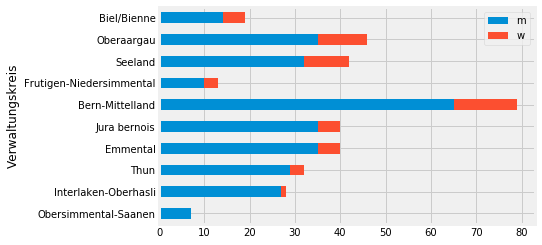

In [27]:
# Wie sieht die Geschlechter-Verteilung in den einzelnen Verwaltungskreisen aus? Die Grafik.
df_gender.sort_values(by='frauen_prozent')[['m', 'w']].plot(kind='barh', stacked=True)

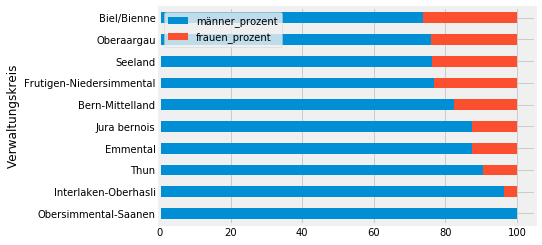

In [28]:
# Wie sieht die Geschlechter-Verteilung in den einzelnen Verwaltungskreisen aus? Grafik mit relativen Zahlen. 
df_gender[['männer_prozent', 'frauen_prozent']].sort_values(by='frauen_prozent').plot(kind='barh', stacked=True)

In [29]:
# Grafik im Datawrapper erstellen. 
dw = Datawrapper(access_token = dw_config.dw_token)
grafik = dw.create_chart(title = 'Es gibt bloss wenige Gemeindepräsidentinnen', chart_type = 'd3-bars-stacked', data = df_gender.reset_index()[['Verwaltungskreis', 'männer_prozent', 'frauen_prozent']])
dw.update_description(grafik['id'], 
                      source_name = 'Kanton Bern',
                      source_url = 'https://www.jgk.be.ch/jgk/de/index/gemeinden/gemeinden/gemeindedaten.html',
                      byline = 'mbb')
dw.publish_chart(grafik['id'])

New chart d3-bars-stacked created!
Chart updated!


/home/this/.local/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [30]:
# Mit diesem Code kann die Grafik im Redaktionssystem eingebunden werden. 
dw.get_iframe_code(grafik['id'])

'<iframe title="Es gibt bloss wenige Gemeindepr&auml;sidentinnen" aria-label="Balken (gestapelt)" src="//datawrapper.dwcdn.net/gF5cf/1/" scrolling="no" frameborder="0" style="border: none;" width="600" height="400"></iframe>'

In [31]:
# Wie gross sind die Gemeinden im Durchschnitt, in denen Männer bzw. Frauen das Gemeindepräsidium innehaben? 
df.groupby(by='geschlecht')[['Einwohner']].mean()

,Einwohner
geschlecht,
m,3082.747405
w,2532.684211


In [32]:
# Achtung: Der Median weicht ziemlich stark vom Mittelwert ab. Wie gross sind die Gemeinden im Mittel, 
# in denen Männer bzw. Frauen das Gemeindepräsidium innehaben? 
df.groupby(by='geschlecht')[['Einwohner']].median()

,Einwohner
geschlecht,
m,1259
w,1062


In [33]:
# Welche Frauen leiten besonders grosse Gemeinden?
df[df['geschlecht'] == 'w'].sort_values(by='Einwohner', ascending=False).head(5)

,Name,Vorname,Gemeinde,geschlecht,BFS,Früherer Amtsbezirk,Regionalkonferenz,Verwaltungsregion,Verwaltungskreis,Wahlkreis ab 01.01.2011,Einwohner,Bemerkung
140,Berlinger-Staub,Annemarie,Köniz,w,355,Bern,Bern-Mittelland,Bern-Mittelland,Bern-Mittelland,Mittelland-Süd,41784,NaN
279,Brunner,Jolanda,Spiez,w,768,Niedersimmental,Thun Oberland-West,Oberland,Frutigen-Niedersimmental,Oberland,12812,NaN
194,Hess,Sandra,Nidau,w,743,Nidau,Biel/Bienne - Seeland - Jura bernois,Seeland,Biel/Bienne,Biel-Seeland,6823,NaN
29,Zuber,Kathrin,Bolligen,w,352,Bern,Bern-Mittelland,Bern-Mittelland,Bern-Mittelland,Mittelland-Nord,6264,NaN
136,Nyffenegger,Marianne,Kirchberg (BE),w,412,Burgdorf,Emmental,Emmental-Oberaargau,Emmental,Emmental,5965,NaN


In [45]:
# Welche Frauen leiten besonders grosse Gemeinden?
df[df['geschlecht'] == 'w'].sort_values(by='Einwohner', ascending=False).head(5)

,Name,Vorname,Gemeinde,geschlecht,BFS,Früherer Amtsbezirk,Regionalkonferenz,Verwaltungsregion,Verwaltungskreis,Wahlkreis ab 01.01.2011,Einwohner,Bemerkung
140,Berlinger-Staub,Annemarie,Köniz,w,355,Bern,Bern-Mittelland,Bern-Mittelland,Bern-Mittelland,Mittelland-Süd,41784,NaN
279,Brunner,Jolanda,Spiez,w,768,Niedersimmental,Thun Oberland-West,Oberland,Frutigen-Niedersimmental,Oberland,12812,NaN
194,Hess,Sandra,Nidau,w,743,Nidau,Biel/Bienne - Seeland - Jura bernois,Seeland,Biel/Bienne,Biel-Seeland,6823,NaN
29,Zuber,Kathrin,Bolligen,w,352,Bern,Bern-Mittelland,Bern-Mittelland,Bern-Mittelland,Mittelland-Nord,6264,NaN
136,Nyffenegger,Marianne,Kirchberg (BE),w,412,Burgdorf,Emmental,Emmental-Oberaargau,Emmental,Emmental,5965,NaN


In [56]:
# Wie viele Gemeinden mit über 10000 Einwohnern gibts im Kanton? 
len(df[df['Einwohner'] > 10000])

17

In [57]:
# Welchen Prozentsatz haben Frauen in den Gemeinden mit über 10000 Einwohnern?
100 * 2 / 17

11.764705882352942

In [53]:
# Wie ist das Geschlechterverhältnis bei den 100 kleinsten Gemeinden?
df.sort_values(by='Einwohner').head(100)['geschlecht'].value_counts()

m    78
w    22
Name: geschlecht, dtype: int64

In [58]:
# Welchen Prozentsatz haben Frauen in den 200 kleinsten Gemeinden? 
100 * 22 / 78

28.205128205128204

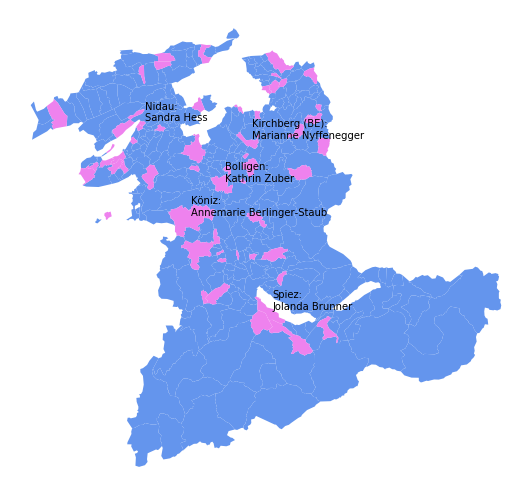

In [34]:
# Karte mit der Geschlechterverteilung. 
# Generieren einer Gemeindekarte. 
gdf = gpd.read_file('../../grundlagendaten/karten/gemeindegrenzen/2019/g1g19.shp')
gdf.crs = {'init' :'epsg:2056'}

# Der eigentliche Datensatz wird angefügt.
gdf['GMDNR'] = gdf['GMDNR'].astype('int')
gdf = gdf[gdf['KTNR'] == 2]
gdf = pd.merge(gdf, df, left_on='GMDNR', right_on='BFS', how='left')

# Plotten der Karte
fig, ax = plt.subplots(1, figsize=(12, 7))
for g in ['m', 'w']:
    c = {'m': 'cornflowerblue', 'w': 'violet'}
    gdf[gdf['geschlecht'] == g].plot(ax = ax, color=c[g])


# Die Beschriftungen werden hinzugefügt. 
for x, y, b, g, v, n in zip(gdf['geometry'].centroid.x, gdf['geometry'].centroid.y, gdf['BFS'], gdf['Gemeinde'], gdf['Vorname'], gdf['Name']):
    if b in [355, 768, 743, 352, 412]:
        t = g + ':\n' + v + ' ' + n
        ax.annotate(t, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.axis('off')

# Abspeichern der Karte. 
plt.tight_layout()
plt.savefig('output/karte.svg')